# Question1

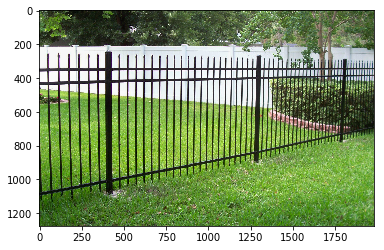

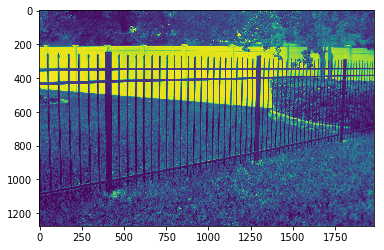

In [1]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


img_orignal = mpimg.imread('aluminum_fence_6.jpg') # Image 
img=np.array(img_orignal[:,:,2])# one channel taken from the image
plt.figure(1)
imgplot = plt.imshow(img_orignal)#orignal image
plt.show()

plt.figure(2)
imgplot = plt.imshow(img)#one channel image
plt.show()

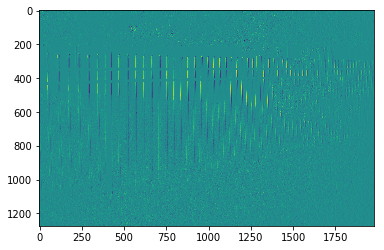

In [2]:
filter=np.array([[1,-1],[1,-1]]) #Filter used for the given image
output = np.zeros((img.shape[0]-1, img.shape[1]-1)) #Output created with size one less than orignal image as we take 2*@ filter

stride=1
for x in range(img.shape[0]-1):
    for y in range(img.shape[1]-1):
        output[x,y]= np.sum(img[x:x+2,y:y+2] * filter) # filter multipled with repective values and added
plt.imshow(output, interpolation='nearest')#one channel image after applying filter
plt.show()

### We have taken a image and took only red channel from the image. Both the images are shown above. Then we took a filter 2*2 dimension and applied it to the one channel image and took respective values in output. We have shown output as shown above.

# Question2

## 2.1

In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import sys

In [12]:
tf.__version__

'1.6.0'

In [13]:
#Convolutional layer 1
filter_size1=5
filter_num1=32

#Convolutional layer 2
filter_size2=5
filter_num2=64

#Convolutional layer 3
filter_size3=5
filter_num3=128

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
num_classes = len(classes)

In [16]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
indices = np.isin(train_labels, classes)
sample_train_data = train_data[indices, :]
sample_train_labels = train_labels[indices]

eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
indices_test = np.isin(eval_labels, classes)
sample_eval_data = eval_data[indices_test, :]
sample_eval_labels = eval_labels[indices_test]

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [19]:

def my_cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    # Computes 32 features using a 5x5 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 28, 28, 1]
    # Output Tensor Shape: [batch_size, 28, 28, 32]
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=filter_num1,
        kernel_size=[filter_size1, filter_size1],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 28, 28, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    pool1_flat = tf.reshape(pool1, [-1, 14 * 14 * 32])
    return further_action(pool1_flat,mode,labels)


   
    

In [20]:
# Dense Layer
# Densely connected layer with 1024 neurons
# Input Tensor Shape: [batch_size, 7 * 7 * 64]
# Output Tensor Shape: [batch_size, 1024]
def further_action(pool_flat,mode,labels):
    dense = tf.layers.dense(inputs=pool_flat, units=1024, activation=tf.nn.relu)

        # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

        # Logits layer
        # Input Tensor Shape: [batch_size, 1024]
        # Output Tensor Shape: [batch_size, 10]
    logits = tf.layers.dense(inputs=dropout, units=num_classes)

    predictions = {
            # Generate predictions (for PREDICT and EVAL mode)
            "classes": tf.argmax(input=logits, axis=1),
            # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
            # `logging_hook`.
            "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
        }
    if mode == tf.estimator.ModeKeys.PREDICT:
            return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

        # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

        # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
            train_op = optimizer.minimize(
                loss=loss,
                global_step=tf.train.get_global_step())
            return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

            #  Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
            "accuracy": tf.metrics.accuracy(
                labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
            mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [15]:
mnist_classifier = tf.estimator.Estimator(
    model_fn=my_cnn_model_fn)  # , model_dir="/tmp/mnist_convnet_model")

# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": sample_train_data},
    y=sample_train_labels,
    batch_size=10,
    num_epochs=None,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=10000)

# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": sample_eval_data},
    y=sample_eval_labels,
    batch_size=100,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x181eae50d0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/var/folders/nd/szd03chx0t5902t9tvr7t78m0000gn/T/tmpRT4h6M', '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/nd/szd03chx0t5902t9tvr7t78m0000

### when appiled only one layer and we run the code we get the following output:- {'loss': 0.24219063, 'global_step': 10000, 'accuracy': 0.9301}

In [6]:
## 2.2

In [16]:
def my_cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    # Computes 32 features using a 5x5 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 28, 28, 1]
    # Output Tensor Shape: [batch_size, 28, 28, 32]
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=filter_num1,
        kernel_size=[filter_size1, filter_size1],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 28, 28, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=filter_num2,
        kernel_size=[filter_size2, filter_size2],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #3
    # second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 28, 28, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 32]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    conv3 = tf.layers.conv2d(
        inputs=pool2,
        filters=filter_num3,
        kernel_size=[filter_size3, filter_size3],
        padding="same",
        activation=tf.nn.relu)
    
    # Pooling Layer #3
    # third max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 28, 28, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 32
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[3 , 3], strides=2)
    
    pool_flat = tf.reshape(pool3, [-1, 3 * 3 * filter_num3])
    return further_action(pool_flat,mode,labels)



In [17]:
mnist_classifier = tf.estimator.Estimator(
    model_fn=my_cnn_model_fn)  # , model_dir="/tmp/mnist_convnet_model")

# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": sample_train_data},
    y=sample_train_labels,
    batch_size=10,
    num_epochs=None,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=10000)

# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": sample_eval_data},
    y=sample_eval_labels,
    batch_size=100,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x181eacac10>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/var/folders/nd/szd03chx0t5902t9tvr7t78m0000gn/T/tmpcoTeJI', '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/nd/szd03chx0t5902t9tvr7t78m0000

### when we applied three layers we get the following output:- {'loss': 0.16099648, 'global_step': 10000, 'accuracy': 0.9505}
### the third layer contains 5*5 filter with 128 filter numbers.

In [21]:
def my_cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST images are 28x28 pixels, and have one color channel
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # Convolutional Layer #1
  # Computes 32 features using a 5x5 filter with ReLU activation.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 28, 28, 1]
  # Output Tensor Shape: [batch_size, 28, 28, 32]
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  # First max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 28, 28, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 32]
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2
  # Computes 64 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 14, 14, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 64]
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 14, 14, 64]
  # Output Tensor Shape: [batch_size, 7, 7, 64]
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 7, 7, 64]
  # Output Tensor Shape: [batch_size, 7 * 7 * 64]
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
  return further_action(pool2_flat,mode,labels)



In [22]:
mnist_classifier = tf.estimator.Estimator(
    model_fn=my_cnn_model_fn)  # , model_dir="/tmp/mnist_convnet_model")

# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": sample_train_data},
    y=sample_train_labels,
    batch_size=10,
    num_epochs=None,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=10000)

# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": sample_eval_data},
    y=sample_eval_labels,
    batch_size=100,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x113476810>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/var/folders/nd/szd03chx0t5902t9tvr7t78m0000gn/T/tmppF_WqV', '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/nd/szd03chx0t5902t9tvr7t78m0000g

### when we applied two layers we get the following output:- {'loss': 0.18964016, 'global_step': 10000, 'accuracy': 0.9438}

## 2.3

## Analysis
### I have implemented CNN with one, two and three layers as shown above.In every layer I ran for 10000 steps with 10 batch_size for train input.  I got the loss and accuracy for each time I ran the code for layers.
#### Layer1: Loss-0.242 and Accuracy:-0.903
#### Layer2: Loss-0.189 and Accuracy:-0.943
#### Layer3: Loss-0.160 and Accuracy:-0.950
#### Thus from the anwithalysis I came to conclusion that as I increased my layers my time for each step got increased. For example CNN with 3 layers took around 44s to run all step where as CNN with 2 layers took 38s for all step and CNN with 1 layer took around 32 s for all step. Moreover my loss decreased as we increased the no of layers and my accuracy increased. 
#### Thus adding more layers increases the complexity of the network, it performs well on training dataset. We have to check that it does not overfit on test data. 


## 2.4

In [1]:
list_of_perc=[0,10,25,50,75,100]
list_of_accuracy=[]

In [2]:
import random

def shuffle(train_label,perc):
    to_shuffle = int((len(train_label) * perc) / 100)
    indicies = random.sample(xrange(len(train_label)), to_shuffle)
    for i in indicies:
        train_label[i]=np.random.choice(np.setdiff1d(classes,[train_label[i]]))

    return train_label

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import sys



classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
num_classes = len(classes)
def Noise_Perc(x):
    
    def my_cnn_model_fn(features, labels, mode):
      """Model function for CNN."""
      # Input Layer
      # Reshape X to 4-D tensor: [batch_size, width, height, channels]
      # MNIST images are 28x28 pixels, and have one color channel
      tf.set_random_seed(1234)
      input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

      # Convolutional Layer #1
      # Computes 32 features using a 5x5 filter with ReLU activation.
      # Padding is added to preserve width and height.
      # Input Tensor Shape: [batch_size, 28, 28, 1]
      # Output Tensor Shape: [batch_size, 28, 28, 32]
      conv1 = tf.layers.conv2d(
          inputs=input_layer,
          filters=32,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)

      # Pooling Layer #1
      # First max pooling layer with a 2x2 filter and stride of 2
      # Input Tensor Shape: [batch_size, 28, 28, 32]
      # Output Tensor Shape: [batch_size, 14, 14, 32]
      pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

      # Convolutional Layer #2
      # Computes 64 features using a 5x5 filter.
      # Padding is added to preserve width and height.
      # Input Tensor Shape: [batch_size, 14, 14, 32]
      # Output Tensor Shape: [batch_size, 14, 14, 64]
      conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)

      # Pooling Layer #2
      # Second max pooling layer with a 2x2 filter and stride of 2
      # Input Tensor Shape: [batch_size, 14, 14, 64]
      # Output Tensor Shape: [batch_size, 7, 7, 64]
      pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

      # Flatten tensor into a batch of vectors
      # Input Tensor Shape: [batch_size, 7, 7, 64]
      # Output Tensor Shape: [batch_size, 7 * 7 * 64]
      pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

      # Dense Layer
      # Densely connected layer with 1024 neurons
      # Input Tensor Shape: [batch_size, 7 * 7 * 64]
      # Output Tensor Shape: [batch_size, 1024]
      dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

      # Add dropout operation; 0.6 probability that element will be kept
      dropout = tf.layers.dropout(
          inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

      # Logits layer
      # Input Tensor Shape: [batch_size, 1024]
      # Output Tensor Shape: [batch_size, 10]
      logits = tf.layers.dense(inputs=dropout, units= num_classes)

      predictions = {
          # Generate predictions (for PREDICT and EVAL mode)
          "classes": tf.argmax(input=logits, axis=1),
          # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
          # `logging_hook`.
          "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
      }
      
      if mode == tf.estimator.ModeKeys.PREDICT:
            
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
      

      # Calculate Loss (for both TRAIN and EVAL modes)
      loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    

      # Configure the Training Op (for TRAIN mode)
      if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

     #  Add evaluation metrics (for EVAL mode)
      eval_metric_ops = {
          "accuracy": tf.metrics.accuracy(
              labels=labels, predictions=predictions["classes"])}
      return tf.estimator.EstimatorSpec(
          mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)
    mnist = tf.contrib.learn.datasets.load_dataset("mnist")

    train_data = mnist.train.images  # Returns np.array
    train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
    
    indices = np.isin(train_labels, classes)
    sample_train_data = train_data[indices, :]
    sample_train_label = train_labels[indices]
    sample_train_labels=shuffle(sample_train_label,x)
    eval_data = mnist.test.images  # Returns np.array
    eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
    indices_test = np.isin(eval_labels, classes)
    sample_eval_data = eval_data[indices_test, :]
    sample_eval_labels = eval_labels[indices_test]


   
    

      # Create the Estimator
    mnist_classifier = tf.estimator.Estimator(
          model_fn=my_cnn_model_fn)#, model_dir="/tmp/mnist_convnet_model")

      # Train the model
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
          x={"x": sample_train_data},
          y=sample_train_labels,
          batch_size=10,
          num_epochs=None,
          shuffle=True)
    mnist_classifier.train(
          input_fn=train_input_fn,
          steps=1000)

      # Evaluate the model and print results
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
          x={"x": sample_eval_data},
          y=sample_eval_labels,
          batch_size=100,
          num_epochs=1,
          shuffle=False)
    eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
    return eval_results['accuracy']
    
    

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
for i in list_of_perc:
    print (i)
    list_of_accuracy.append(Noise_Perc(i))

0
Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c23476ad0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/var/folders/nd/szd03chx0t5902t9tvr7t78m0000gn/T/tmpg6Au5_', '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflo

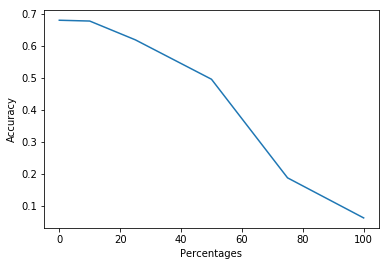

In [5]:
import matplotlib.pyplot as plt
plt.plot(list_of_perc, list_of_accuracy)
plt.xlabel("Percentages")
plt.ylabel("Accuracy")
plt.show()


### In this I have added noise in train labels as given:
### I took the count of percentage of values we have to change. Then based on count I selected the indices , if the percentage is 100% it will take all the indices and replaced the value with the classvalue other than the class was holding initially. Thus in this way if percentage is 100%, I get all the values changed of train labels. Then as per instruction for all noise percentage I ran the CNN with 2 layers. I have plotted the accuracy I got vs Percentage of noise.